# MoneyLion Machine Learning Scientist Take Home Assessment 

Predict Bank Transaction Category Challenge by Johnston Yap | johnstonyap.jy@gmail.com | +6011-1113 3792
- Time Spent : 10 hours
- Notice : Summary.pdf and at Step 6 Discussion **( located at the bottom )**

** ** 
#### Setting Up Your Environment

To ensure that you have all the necessary libraries, you can use the `requirements.txt` file. Run the following command in your terminal:

    pip install -r requirements.txt
     

### Import Libraries

In [2]:
import pandas as pd
from IPython.display import display
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import joblib
import os
import time

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')



## Load and Understand Data

In [3]:
bank_transactions = pd.read_csv("bank_transaction.csv")
user_profiles = pd.read_csv("user_profile.csv")

# Display data
print("Bank Transaction Data:")
display(bank_transactions.head())

print("User Profile Data:")
display(user_profiles.head())

Bank Transaction Data:


,client_id,bank_id,account_id,txn_id,txn_date,description,amount,category
0,1,1,1,4,2023-09-29 00:00:00,Earnin PAYMENT Donat...,20.0,Loans
1,1,1,1,3,2023-08-14 00:00:00,ONLINE TRANSFER FROM NDonatas DanyalDA O CARSO...,25.0,Transfer Credit
2,1,1,1,5,2023-09-25 00:00:00,MONEY TRANSFER AUTHOR...,20.0,Loans
3,1,1,2,1,2023-06-02 00:00:00,ONLINE TRANSFER FROM CARSON N EVERYDAY CHECKIN...,16.0,Transfer Credit
4,1,1,2,2,2023-06-01 00:00:00,ONLINE TRANSFER FROM CARSON N EVERYDAY CHECKIN...,4.0,Transfer Credit


User Profile Data:


,CLIENT_ID,IS_INTERESTED_INVESTMENT,IS_INTERESTED_BUILD_CREDIT,IS_INTERESTED_INCREASE_INCOME,IS_INTERESTED_PAY_OFF_DEBT,IS_INTERESTED_MANAGE_SPENDING,IS_INTERESTED_GROW_SAVINGS
0,1,False,False,False,False,False,False
1,2,False,False,False,False,False,False
2,3,False,False,False,False,False,False
3,4,False,True,True,True,True,True
4,5,True,False,True,True,True,False


In [4]:
# display information on imported data
print("Bank Transaction Info :")
print(bank_transactions.info())
print()

print("User Profile Info :")
print(user_profiles.info())

Bank Transaction Info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258779 entries, 0 to 258778
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   client_id    258779 non-null  int64  
 1   bank_id      258779 non-null  int64  
 2   account_id   258779 non-null  int64  
 3   txn_id       258779 non-null  int64  
 4   txn_date     258779 non-null  object 
 5   description  258779 non-null  object 
 6   amount       258779 non-null  float64
 7   category     258522 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 15.8+ MB
None

User Profile Info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   CLIENT_ID                      1000 non-null   int64
 1   IS_INTERESTED_INVESTMENT       1000 non-null   bool 
 2   IS_IN

## Data Visualization

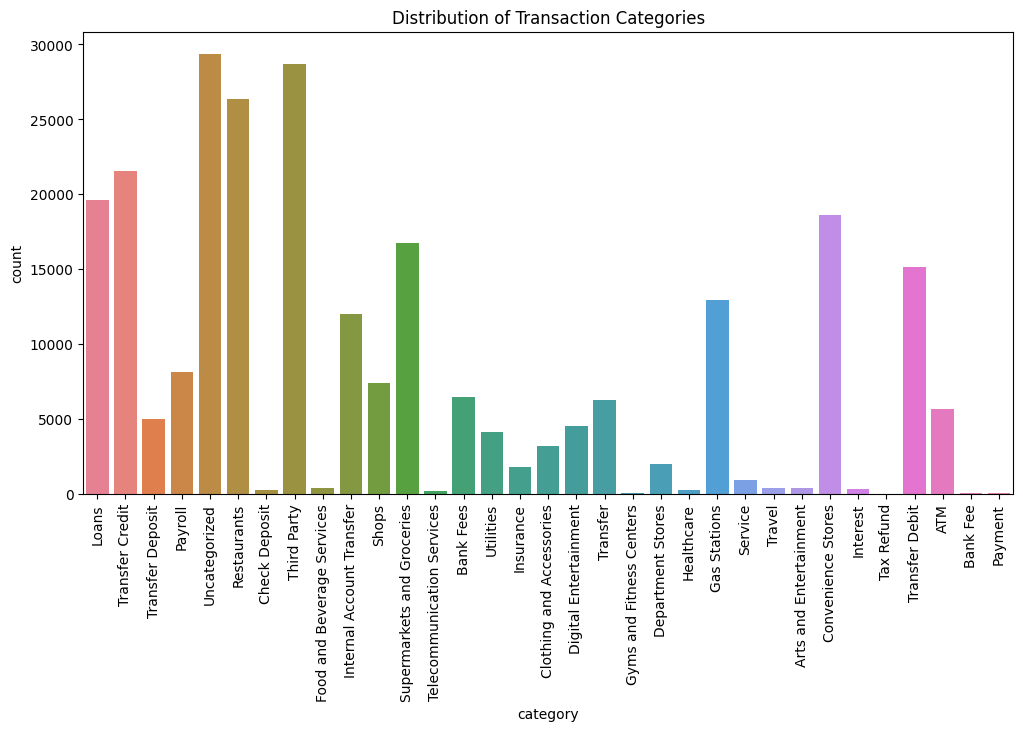

In [5]:
# Create a palette with exactly the number of colors needed
palette = sns.color_palette("husl", len(bank_transactions['category'].unique())-1)

# Plot
plt.figure(figsize=(12, 6))
sns.countplot(data=bank_transactions, x='category', palette=palette, hue=None)
plt.title('Distribution of Transaction Categories')
plt.xticks(rotation=90)
plt.show()

# Step 1 : Data Preprocessing

## 1.1 Drop NaN Value

In [6]:
# Check the count of NaN values in each column
nan_counts = bank_transactions.isna().sum()

print("NaN counts for each column in 'bank_transactions':")
print(nan_counts)

# Show the count of rows before and after dropping
print(f"\nTotal rows before dropping : {len(bank_transactions)}")

# Drop rows with NaN values in the 'description' column
bank_transactions = bank_transactions.dropna(subset=['category'])

print(f"Total rows after dropping  : {len(bank_transactions)}")

NaN counts for each column in 'bank_transactions':
client_id        0
bank_id          0
account_id       0
txn_id           0
txn_date         0
description      0
amount           0
category       257
dtype: int64

Total rows before dropping : 258779
Total rows after dropping  : 258522


## 1.2 Check Unique Category list

In [7]:
# List of expected categories : 'category'

# Arts and Entertainment
# ATM
# Bank Fees
# Check Deposit
# Clothing and Accessories
# Convenience Stores
# Department Stores
# Digital Entertainment
# Food and Beverage Services
# Gas Stations
# Gyms and Fitness Centers
# Healthcare
# Insurance
# Interest
# Internal Account Transfer
# Loans
# Payment
# Payroll
# Restaurants
# Service
# Shops
# Supermarkets and Groceries
# Tax Refund
# Telecommunication Services
# Third Party
# Transfer Credit
# Transfer Debit
# Transfer Deposit
# Travel
# Utilities

# Get the unique categories and sort them
unique_categories = sorted(bank_transactions['category'].unique())

# Print the unique categories in ascending order
print("Unique categories in ascending order:")
for i, category in enumerate(unique_categories, 1):
    print(f"{i}. {category}")

Unique categories in ascending order:
1. ATM
2. Arts and Entertainment
3. Bank Fee
4. Bank Fees
5. Check Deposit
6. Clothing and Accessories
7. Convenience Stores
8. Department Stores
9. Digital Entertainment
10. Food and Beverage Services
11. Gas Stations
12. Gyms and Fitness Centers
13. Healthcare
14. Insurance
15. Interest
16. Internal Account Transfer
17. Loans
18. Payment
19. Payroll
20. Restaurants
21. Service
22. Shops
23. Supermarkets and Groceries
24. Tax Refund
25. Telecommunication Services
26. Third Party
27. Transfer
28. Transfer Credit
29. Transfer Debit
30. Transfer Deposit
31. Travel
32. Uncategorized
33. Utilities


#### Code below : For examination on description purposes

In [8]:
# Set display options to show more rows ( only for this cell)
pd.set_option('display.max_rows', None)  # None means no limit
pd.set_option('display.max_columns', None)  # Adjust as needed

# Display 20 rows for each category for visual sample
sampled_data = bank_transactions.groupby('category', group_keys=False).apply(
    lambda x: x.sample(min(len(x), 20), random_state=1)
)[['description', 'category']]

# Display the sampled data
display(sampled_data)

,description,category
125891,BKOFAMMaryse Hemant ATM 09/09 #3168 WITHDRWL M...,ATM
135609,NON-CHASE ATM WITHDRAW 387631 1036 Whit,ATM
140121,ATM Withdrawal,ATM
68692,ATM Withdrawal,ATM
85011,ATM WITHDRAWAL AUTHORIZED ON ...,ATM
145392,ATM Withdrawal,ATM
250341,ATM WITHDRAWAL 1036 W VE,ATM
254485,NON-WF ATM WITHDRAWAL AUTHORIZED ON 1036 W. HA...,ATM
226564,ATM Withdrawal,ATM
160797,ATM WITHDRAWAL MACTX93828N0902 0233 158 TULIP ...,ATM


## 1.3 Data Transformation & Filtering

In [9]:
# According to the data_dictionary only 30 unique category are stated
# Notice : that there're similarity between Bank Fee and Bank Fees which typo may occur, a merge is suitable
# Notice : Transfer can't be calssify as Debit or Credit or Deposit, hence to be removed to avoid misunderstanding
# Notice : Uncategorized are not eligible for training and testing due to lack of guidance, hence to be removed

# Print total length before any changes
total_length_before = len(bank_transactions)
print(f"Total length before changes : {total_length_before}")

# Count of rows for specific categories before changes
bank_fee_count_before = bank_transactions[bank_transactions['category'] == 'Bank Fee'].shape[0]
bank_fees_count_before = bank_transactions[bank_transactions['category'] == 'Bank Fees'].shape[0]
transfer_count_before = bank_transactions[bank_transactions['category'] == 'Transfer'].shape[0]
uncategorized_count_before = bank_transactions[bank_transactions['category'] == 'Uncategorized'].shape[0]

print(f"\nCount of 'Bank Fee' before changes      : {bank_fee_count_before}")
print(f"Count of 'Bank Fees' before changes     : {bank_fees_count_before}")
print(f"Count of 'Transfer' before changes      : {transfer_count_before}")
print(f"Count of 'Uncategorized' before changes : {uncategorized_count_before}")

# Rename 'Bank Fee' to 'Bank Fees'
bank_transactions['category'] = bank_transactions['category'].replace('Bank Fee', 'Bank Fees')

# Remove rows where category is 'Transfer' or 'Uncategorized'
bank_transactions = bank_transactions[~bank_transactions['category'].isin(['Transfer', 'Uncategorized'])]

# Reset index after filtering
bank_transactions = bank_transactions.reset_index(drop=True)

# Print total length after changes
total_length_after = len(bank_transactions)
print(f"\nTotal length after changes : {total_length_after}")

# Count of rows for 'Bank Fees' after changes
bank_fees_count_after = bank_transactions[bank_transactions['category'] == 'Bank Fees'].shape[0]

# Calculate number of rows removed
rows_removed = total_length_before - total_length_after

print(f"Count of 'Bank Fees' after changes : {bank_fees_count_after}")
print(f"Number of rows removed             : {rows_removed}")


# Get the unique categories and sort them
unique_categories = sorted(bank_transactions['category'].unique())

# Print the unique categories in ascending order
print("\nUnique categories in ascending order:")
for i, category in enumerate(unique_categories, 1):
    print(f"{i}. {category}")


Total length before changes : 258522

Count of 'Bank Fee' before changes      : 36
Count of 'Bank Fees' before changes     : 6432
Count of 'Transfer' before changes      : 6275
Count of 'Uncategorized' before changes : 29392

Total length after changes : 222855
Count of 'Bank Fees' after changes : 6468
Number of rows removed             : 35667

Unique categories in ascending order:
1. ATM
2. Arts and Entertainment
3. Bank Fees
4. Check Deposit
5. Clothing and Accessories
6. Convenience Stores
7. Department Stores
8. Digital Entertainment
9. Food and Beverage Services
10. Gas Stations
11. Gyms and Fitness Centers
12. Healthcare
13. Insurance
14. Interest
15. Internal Account Transfer
16. Loans
17. Payment
18. Payroll
19. Restaurants
20. Service
21. Shops
22. Supermarkets and Groceries
23. Tax Refund
24. Telecommunication Services
25. Third Party
26. Transfer Credit
27. Transfer Debit
28. Transfer Deposit
29. Travel
30. Utilities


## 1.4 Preprocess Data

In [10]:
# Cached Stopwords / Pattern outside functions and reused to reduce time complexity
# Initialize the Lemmatizer and Stopwords set
# lemmatizer = WordNetLemmatizer()
# stop_words = set(stopwords.words('english'))

# Compile regex patterns
space_pattern = re.compile(r'\s+')
non_word_pattern = re.compile(r'\W+')
numeric_pattern = re.compile(r'\b\d+\b')

def preprocess_description(description):
    # Remove extra spaces and punctuation
    description = space_pattern.sub(' ', description)  # Replace multiple spaces with one
    description = non_word_pattern.sub(' ', description)  # Replace non-word characters with space
    description = numeric_pattern.sub('', description)  # Remove standalone numeric values
    description = description.lower().strip()  # Remove leading and trailing spaces
    
    # Tokenization
    tokens = word_tokenize(description)
    
    # Removing Stopwords and Lemmatization
    # tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]   # back to its original form ( commented to maintain the features )
    
    return ' '.join(tokens)


print("\nBefore Cleaning Bank Transaction Data : Descriptions \n", bank_transactions['description'].tail(20).to_string())

# Apply preprocessing to descriptions
bank_transactions['cleaned_description'] = bank_transactions['description'].apply(preprocess_description)

print("\nAfter Cleaning Bank Transaction Data : Descriptions\n", bank_transactions['cleaned_description'].tail(20).to_string())



Before Cleaning Bank Transaction Data : Descriptions 
 222835    PURCHASE AUTHORIZED ON 07/03 ALDI 71074 Maryse...
222836    RECURRING PAYMENT AUTHORIZED ON 09/02 PARAMOUN...
222837    APLFCU CK WEBXFR TRANSFER 230712 1036 Maryse H...
222838    NON-WF ATM WITHDRAWAL AUTHORIZED ON 1036 PENRO...
222839                       PURCHASE HOLIDAY STATIONS 0203
222840    PURCHASE AUTHORIZED ON 06/13 DUNKIN' MOBILE AP...
222841              PURCHASE 0912 STARBUCKS 800- SEATTLE WA
222842                                             CHECK111
222843                                             CHECK111
222844    SHOPPERS FOOD/ 09/25 #Maryse Hemant FOOD/PHA B...
222845    WM SUPERCENTER 07/16 #3168 PURCHASE Wal-Mart S...
222846    BKOFAMMaryse Hemant ATM 08/08 #3168 WITHDRWL M...
222847                                             CHECK111
222848                                             CHECK111
222849    TARGET T- 1330 06/18 #3168 PURCHASE TARGET T- ...
222850                                      

# Step 2 : Feature Extraction - TF-IDF

In [11]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the cleaned descriptions
tfidf_matrix = tfidf_vectorizer.fit_transform(bank_transactions['cleaned_description'])

# The tfidf_matrix is now in sparse format and won't be converted to a dense DataFrame.
print(f"Shape of TF-IDF sparse matrix : {tfidf_matrix.shape}")
print(tfidf_matrix)



Shape of TF-IDF sparse matrix : (222855, 46850)
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1151962 stored elements and shape (222855, 46850)>
  Coords	Values
  (0, 14866)	0.4137335693697104
  (0, 29153)	0.31409832960645995
  (0, 14464)	0.6121104955239057
  (0, 13836)	0.5962277368460053
  (1, 25347)	0.1701238174517415
  (1, 44628)	0.1064824863533542
  (1, 17136)	0.12737425118300733
  (1, 24564)	0.5474826852582476
  (1, 13837)	0.5474826852582476
  (1, 12082)	0.40699448612158917
  (1, 10959)	0.3702401888684636
  (1, 12502)	0.20321977381477296
  (2, 14866)	0.26308583623566567
  (2, 44628)	0.12055964458156324
  (2, 17136)	0.14421333476857157
  (2, 23907)	0.19901551427676983
  (2, 9264)	0.18063188160181806
  (2, 25321)	0.17293204509898072
  (2, 12254)	0.619860788470545
  (2, 11686)	0.1576654400394957
  (2, 41711)	0.619860788470545
  (3, 25347)	0.28905096293758653
  (3, 44628)	0.18092037715504708
  (3, 17136)	0.21641678695780645
  (3, 12082)	0.691508983785323
  :	:
  (22284

# Step 3: Split Data into Training and Testing Sets

In [12]:

# Point out 'category' as the target variable for the prediction of transaction category
X = tfidf_matrix
y = bank_transactions['category']

# Split data into training and testing dataset
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training dataset size : {x_train.shape}")
print(f"Testing dataset size : {x_test.shape}")


Training dataset size : (178284, 46850)
Testing dataset size : (44571, 46850)


# Step 4: Model Training and Evaluation

### Functions for Training and Evaluating Model 

- Naive Bayes Model
- Logistic Regression Model
- Random Forest Model
- Support Vector Machine Model

In [13]:
# Implementing Cross-Validation Function for Model Evaluation
def evaluate_model(model, x_train, y_train, x_test, y_test, target_names, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    accuracies = []
    reports = []
    conf_matrices = []
    train_times = []
    predict_times = []
    
    for train_index, val_index in kf.split(x_train):
        x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        start_time = time.time()
        model.fit(x_train_fold, y_train_fold)
        train_time = time.time() - start_time
        
        # Predict on the test set (due to unchanged during cross-validation)
        start_time = time.time()
        y_pred = model.predict(x_test)
        predict_time = time.time() - start_time
        
        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=target_names, zero_division=0)
        conf_matrix = confusion_matrix(y_test, y_pred, labels=target_names)
        
        accuracies.append(accuracy)
        reports.append(report)
        conf_matrices.append(conf_matrix)
        train_times.append(train_time)
        predict_times.append(predict_time)
    
    # Apply mean to find the optimal value
    avg_accuracy = np.mean(accuracies)
    avg_train_time = np.mean(train_times)
    avg_predict_time = np.mean(predict_times)
    
    # Combine confusion matrices
    combined_conf_matrix = np.sum(conf_matrices, axis=0)
    
    # Use the last report (optional) or combine them
    avg_report = reports[-1]

    return model, avg_accuracy, avg_report, combined_conf_matrix, avg_train_time, avg_predict_time


# Function for Confusion Matrix Plotting
def plot_confusion_matrix(conf_matrix, model_name, target_names):
    plt.figure(figsize=(20, 12))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Function to Manage Model
def manage_model(model_name, model, x_train, y_train, x_test, y_test, target_names, n_splits=5):
    model_path = f'models/{model_name.lower().replace(" ", "_")}_model.joblib'
    results_path = 'results/model_evaluation_results.csv'

    if os.path.exists(model_path):
        # Load the model
        print(f"Loading existing {model_name} model...")
        model = joblib.load(model_path)
        # Predict with the existing model
        start_time = time.time()  # Timing for predictions
        y_pred = model.predict(x_test)
        predict_time = time.time() - start_time
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=target_names, zero_division=0)
        conf_matrix = confusion_matrix(y_test, y_pred, labels=target_names)
        results = {
            'model_name': model_name,
            'accuracy': accuracy,
            'classification_report': report,
            'confusion_matrix': conf_matrix,
            'training_time': 0,
            'prediction_time': predict_time
        }
    else:
        print(f"Training and evaluating new {model_name} model...")
        # Train and evaluate the model with cross-validation
        model, accuracy, report, conf_matrix, train_time, predict_time = evaluate_model(
            model, x_train, y_train, x_test, y_test, target_names, n_splits
        )
        # Save the model
        joblib.dump(model, model_path)
        print(f"Model saved to {model_path}")

        # Prepare results
        results = {
            'model_name': model_name,
            'accuracy': accuracy,
            'classification_report': report,
            'confusion_matrix': conf_matrix,
            'training_time': train_time,
            'prediction_time': predict_time
        }
        
        # Prepare data for CSV
        csv_results = {
            'model_name': model_name,
            'accuracy': accuracy,
            'training_time': train_time,
            'prediction_time': predict_time
        }
        
        save_results_to_csv(csv_results)
        
    return results

def save_results_to_csv(results):

    results_path = 'results/model_evaluation_results.csv'

    # Ensure the directory exists
    results_dir = os.path.dirname(results_path)
    os.makedirs(results_dir, exist_ok=True)
    
    # Create DataFrame from results
    results_df = pd.DataFrame([results])
    
    if not os.path.exists(results_path):
        # Save new results if file does not exist
        results_df.to_csv(results_path, index=False)
    else:
        # Append new results if file exists
        existing_df = pd.read_csv(results_path)
        combined_df = pd.concat([existing_df, results_df], ignore_index=True)
        combined_df.to_csv(results_path, index=False)
    
    print(f"Results saved to {results_path}")

### Functions for Value Extraction 

In [14]:
def get_training_time_from_csv(model_name, results_path='results/model_evaluation_results.csv'):
    if os.path.exists(results_path):
        try:
            results_df = pd.read_csv(results_path)
            # Check if model_name exists in the DataFrame
            if 'model_name' in results_df.columns and 'training_time' in results_df.columns:
                model_results = results_df[results_df['model_name'] == model_name]
                if not model_results.empty:
                    training_time = model_results['training_time'].values[0]
                    return training_time
                else:
                    print(f"No results found for model: {model_name}")
                    return 'Not Available'
            else:
                print("CSV file does not contain expected columns.")
                return 'Not Available'
        except Exception as e:
            print(f"Error reading CSV file: {e}")
            return 'Not Available'
    else:
        print("Results CSV file does not exist.")
        return 'Not Available'
    

Loading existing Naive Bayes model...

Naive Bayes Results:
K-Fold Cross Validation : 5
Accuracy: 79.89%
F1 Score: 0.78
Training Time (from CSV): 0.38 seconds
Prediction Time: 0.03 seconds
Classification Report:
                            precision    recall  f1-score   support

        Convenience Stores       0.96      0.93      0.95      1189
                     Loans       0.00      0.00      0.00        84
               Third Party       0.93      0.95      0.94      1298
 Internal Account Transfer       0.00      0.00      0.00        36
              Gas Stations       1.00      0.09      0.17       647
               Restaurants       0.60      0.83      0.70      3618
Supermarkets and Groceries       1.00      0.08      0.15       406
                 Bank Fees       0.91      0.78      0.84       916
                       ATM       0.00      0.00      0.00        74
           Transfer Credit       0.67      0.18      0.28      2603
     Digital Entertainment       0.00  

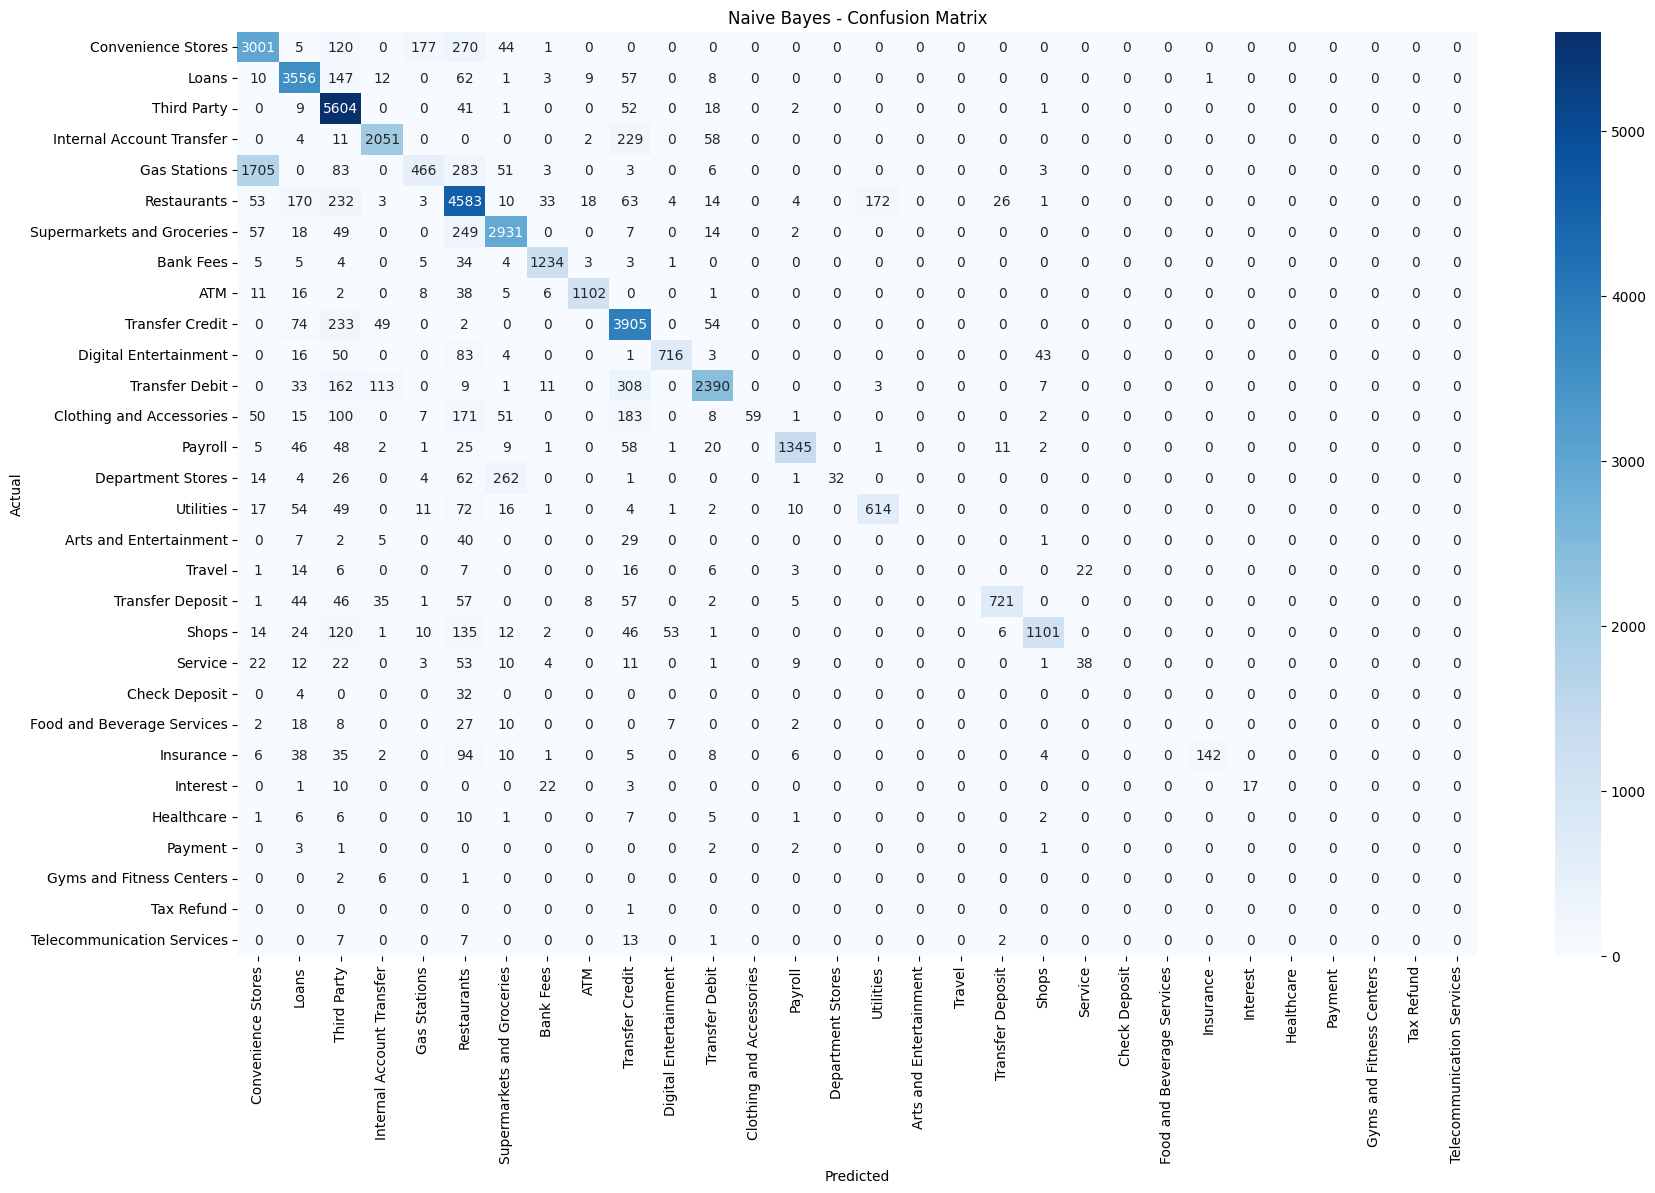

Loading existing Logistic Regression model...

Logistic Regression Results:
K-Fold Cross Validation : 5
Accuracy: 88.63%
F1 Score: 0.88
Training Time (from CSV): 35.14 seconds
Prediction Time: 0.04 seconds
Classification Report:
                            precision    recall  f1-score   support

        Convenience Stores       0.98      0.99      0.99      1189
                     Loans       0.89      0.86      0.87        84
               Third Party       0.98      0.98      0.98      1298
 Internal Account Transfer       0.91      0.81      0.85        36
              Gas Stations       0.86      0.78      0.82       647
               Restaurants       0.66      0.78      0.71      3618
Supermarkets and Groceries       0.91      0.42      0.58       406
                 Bank Fees       0.91      0.93      0.92       916
                       ATM       0.66      0.39      0.49        74
           Transfer Credit       0.65      0.34      0.44      2603
     Digital Entertain

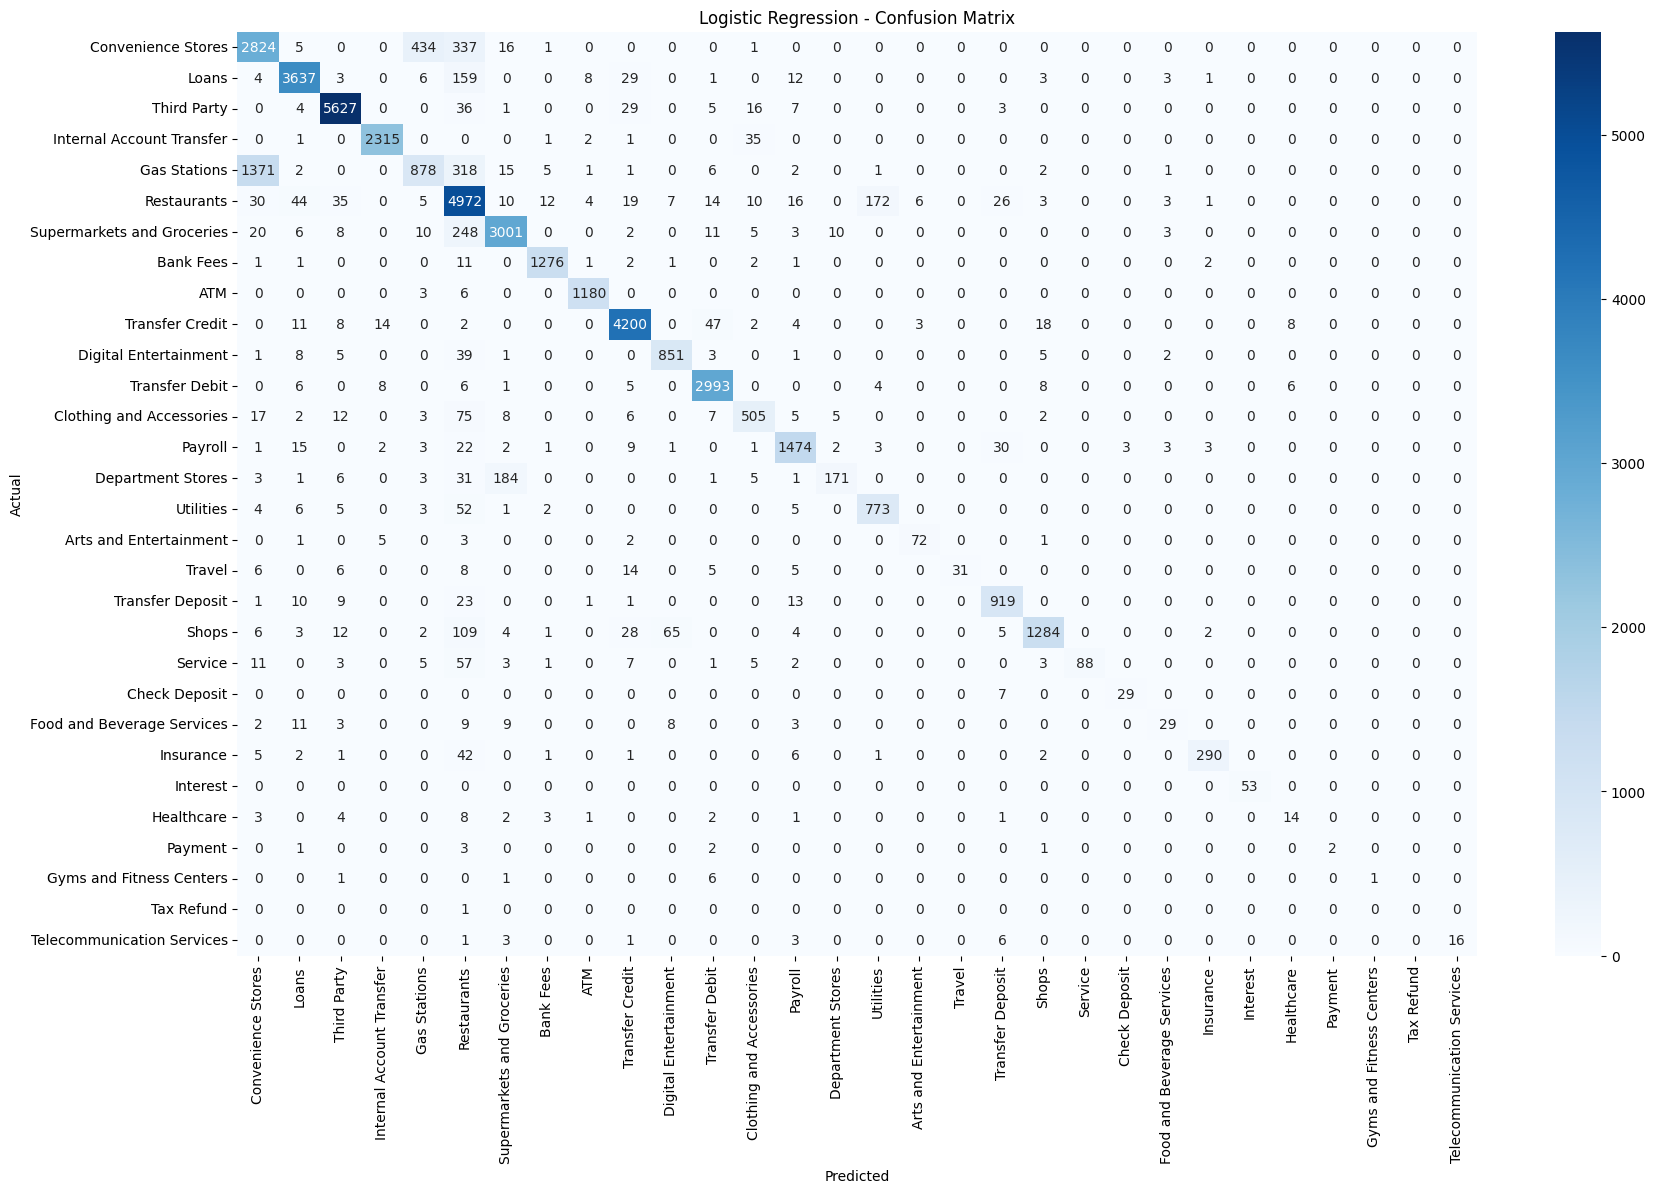

Loading existing Random Forest model...

Random Forest Results:
K-Fold Cross Validation : 5
Accuracy: 89.97%
F1 Score: 0.90
Training Time (from CSV): 201.46 seconds
Prediction Time: 1.32 seconds
Classification Report:
                            precision    recall  f1-score   support

        Convenience Stores       0.99      1.00      0.99      1189
                     Loans       0.89      0.92      0.90        84
               Third Party       0.99      0.99      0.99      1298
 Internal Account Transfer       0.87      0.94      0.91        36
              Gas Stations       0.88      0.79      0.84       647
               Restaurants       0.64      0.79      0.71      3618
Supermarkets and Groceries       0.86      0.52      0.65       406
                 Bank Fees       0.92      0.94      0.93       916
                       ATM       0.71      0.61      0.66        74
           Transfer Credit       0.66      0.40      0.50      2603
     Digital Entertainment       

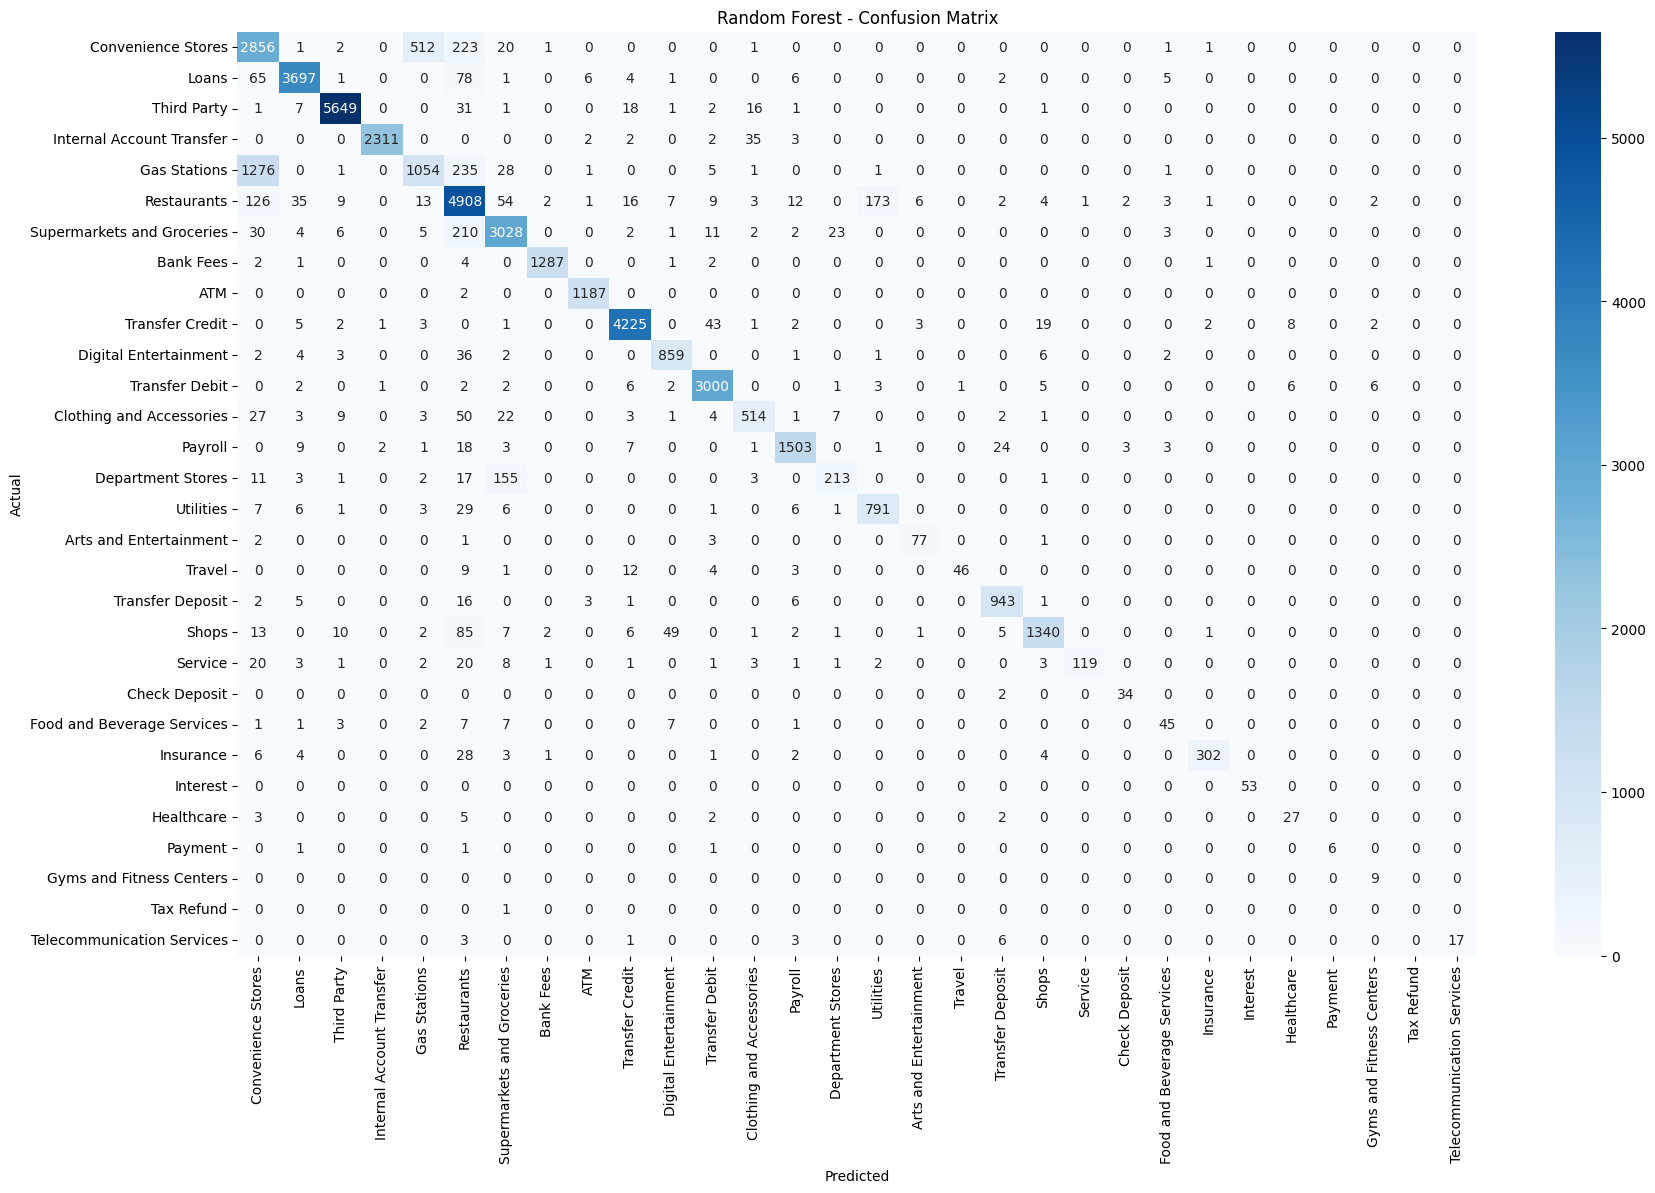

Loading existing SVM model...

SVM Results:
K-Fold Cross Validation : 5
Accuracy: 89.55%
F1 Score: 0.89
Training Time (from CSV): 365.07 seconds
Prediction Time: 414.23 seconds
Classification Report:
                            precision    recall  f1-score   support

        Convenience Stores       0.99      1.00      0.99      1189
                     Loans       0.90      0.94      0.92        84
               Third Party       0.99      0.99      0.99      1298
 Internal Account Transfer       0.92      1.00      0.96        36
              Gas Stations       0.88      0.82      0.85       647
               Restaurants       0.66      0.80      0.72      3618
Supermarkets and Groceries       0.90      0.50      0.64       406
                 Bank Fees       0.91      0.94      0.92       916
                       ATM       0.68      0.54      0.60        74
           Transfer Credit       0.67      0.33      0.44      2603
     Digital Entertainment       1.00      0.22    

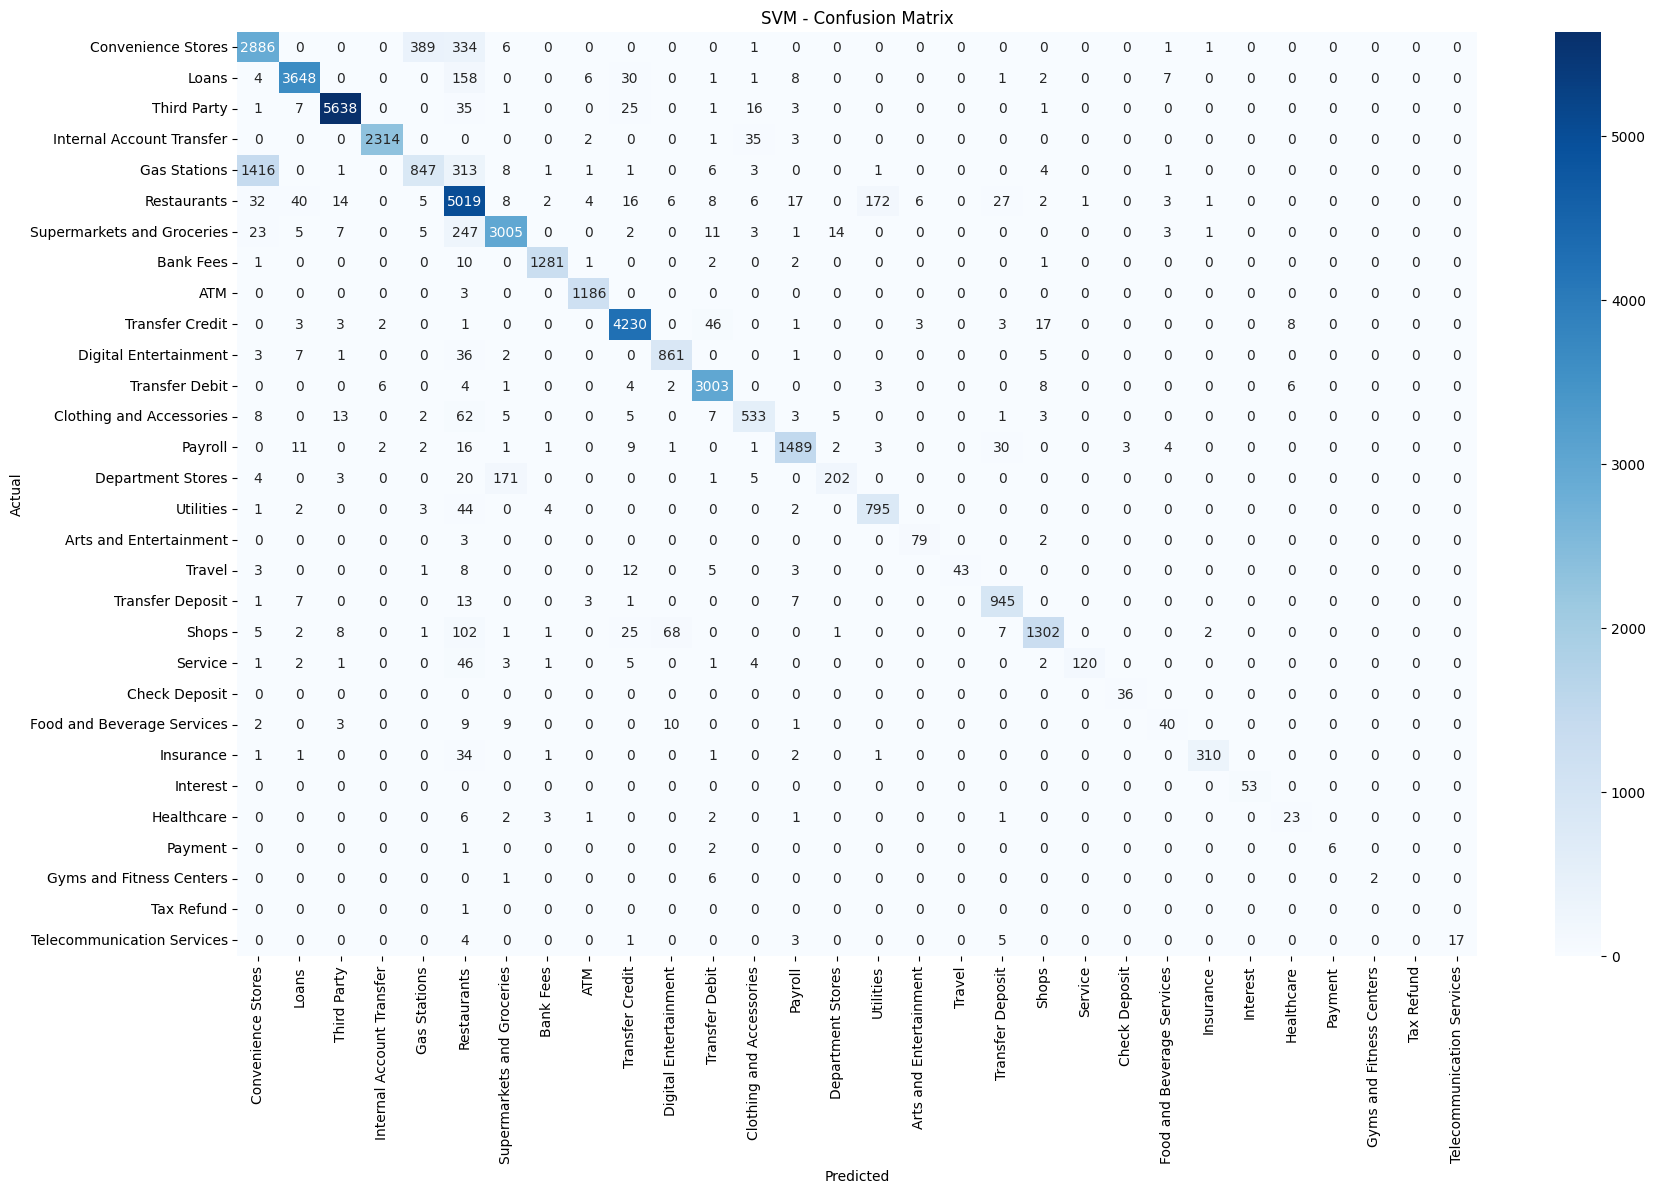

In [15]:
# Define models with names
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_jobs=-1),
    'SVM': SVC(kernel='linear')
}

model_directory_path = 'models'

# Ensure the models directory exists
os.makedirs(model_directory_path, exist_ok=True)

if not os.path.exists(model_directory_path):
    # Create the directory
    os.makedirs(model_directory_path)

# target_names contain unique class names
target_names = y_train.unique()

# Create dictionaries to store metrics
training_times = {}
accuracies = {}
f1_scores = {}

# Manage and evaluate models
for model_name, model in models.items():
    k = 5
    results = manage_model(model_name, model, x_train, y_train, x_test, y_test, target_names, n_splits=k)
    
    # Extract and store F1 score
    accuracies[model_name] = results['accuracy'] * 100  # Convert to percentage
    accuracy = f"{accuracies[model_name]:.2f}"
    
    # Extract and store F1 score
    report = results['classification_report']
    lines = report.split('\n')
    f1_score_line = lines[-2].strip().split() 
    f1_score = f"{float(f1_score_line[4]):.2f}"
    f1_scores[model_name] = f1_score
    
    # Extract and store F1 score training time from CSV
    training_time_csv = get_training_time_from_csv(model_name)
    
    print(f"\n{model_name} Results:")
    print(f"K-Fold Cross Validation : {k}")
    print(f"Accuracy: {accuracy}%")
    print(f"F1 Score: {f1_score}")
        
    # Manage Training Time
    if training_time_csv != 'Not Available':
        training_times[model_name] = training_time_csv
        print(f"Training Time (from CSV): {training_time_csv:.2f} seconds")
    else:
        training_times[model_name] = 'Not Available'
        print(f"Training Time (from CSV): Not Available")
    
    print(f"Prediction Time: {results['prediction_time']:.2f} seconds")
    print(f"Classification Report:\n{results['classification_report']}")
    plot_confusion_matrix(results['confusion_matrix'], model_name, target_names)
    
    # print(f"Completed {model_name}\n")


# Step 5 : Plot and Evaluate the Models


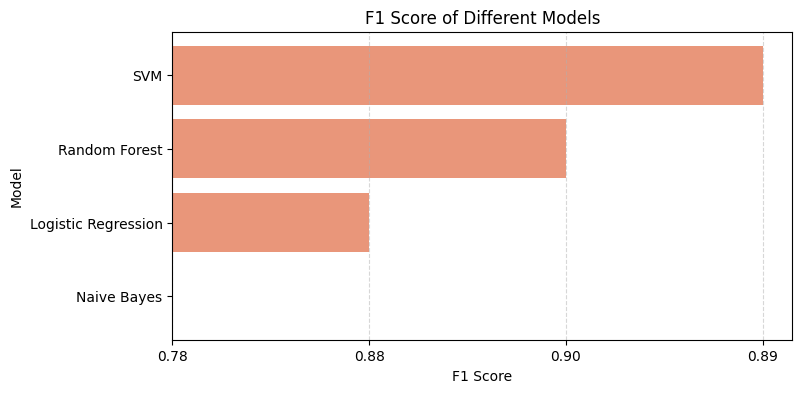

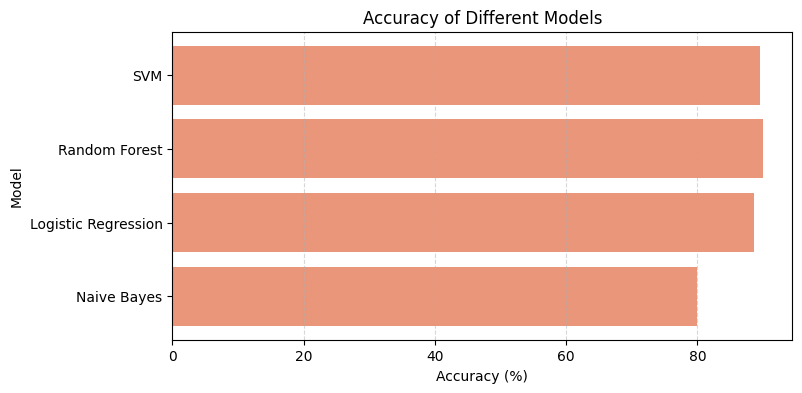

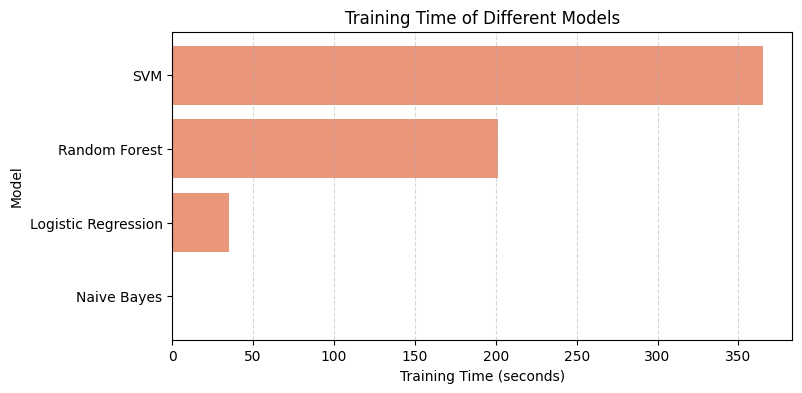

In [16]:
# Function to plot bar charts for Accuracy, F1 Score and Training
def plot_bar_chart(data, title, x_label, y_label):
    if not data:
        print("No data available to plot.")
        return
    
    # Extract data
    labels = list(data.keys())
    values = list(data.values())
    
    # Create the bar chart
    plt.figure(figsize=(8, 4))
    plt.barh(labels, values, color='DarkSalmon')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.show()

# Plot diagram for f1 score, accuracy and training time
plot_bar_chart(f1_scores, 'F1 Score of Different Models', 'F1 Score', 'Model')
plot_bar_chart(accuracies, 'Accuracy of Different Models', 'Accuracy (%)', 'Model')
filtered_training_times = {k: v for k, v in training_times.items() if v != 'Not Available'}
plot_bar_chart(filtered_training_times, 'Training Time of Different Models', 'Training Time (seconds)', 'Model')

### Find Highest F1 Score Model

In [17]:
# display all values according to the model
data = {
    'Model': list(models.keys()),
    'Training Time (seconds)': [training_times.get(model, 'Not Available') for model in models.keys()],
    'Accuracy (%)': [accuracies.get(model, 'Not Available') for model in models.keys()],
    'F1 Score': [f1_scores.get(model, 'Not Available') for model in models.keys()]
}

data_df = pd.DataFrame(data)

# Display the combined DataFrame
display(data_df)

# Print the model with the best F1 score
best_f1_score_model = max(f1_scores, key=f1_scores.get)
best_f1_score = f1_scores[best_f1_score_model]
print(f"\nBest F1 Score Model: {best_f1_score_model} with an F1 Score of {best_f1_score}")


,Model,Training Time (seconds),Accuracy (%),F1 Score
0,Naive Bayes,0.376576,79.890512,0.78
1,Logistic Regression,35.135836,88.633865,0.88
2,Random Forest,201.464960,89.968814,0.90
3,SVM,365.074024,89.549258,0.89



Best F1 Score Model: Random Forest with an F1 Score of 0.90


### Find Best Overall Model based on  ( F1 Score & Training Time )

In [18]:
# Assuming data is already loaded into the 'data' variable
data_df = pd.DataFrame(data)

# Replace 'Not Available' with NaN for numerical operations
data_df.replace('Not Available', np.nan, inplace=True)

# Convert the 'Training Time (seconds)' and 'F1 Score' columns to numeric types
data_df['Training Time (seconds)'] = pd.to_numeric(data_df['Training Time (seconds)'], errors='coerce')
data_df['F1 Score'] = pd.to_numeric(data_df['F1 Score'], errors='coerce')

# Handle missing values (NaN)
data_df['Training Time (seconds)'].fillna(0, inplace=True)
data_df['F1 Score'].fillna(0, inplace=True)

min_train_time = data_df['Training Time (seconds)'].min()
max_train_time = data_df['Training Time (seconds)'].max()

min_f1_score = data_df['F1 Score'].min()
max_f1_score = data_df['F1 Score'].max()

# Normalize the Training Time (lower is better)
data_df['Normalized Training Time'] = (max_train_time - data_df['Training Time (seconds)']) / \
                                  (max_train_time - min_train_time)

# Normalize the F1 Score (higher is better)
data_df['Normalized F1 Score'] = (data_df['F1 Score'] - min_f1_score) / \
                             (max_f1_score - min_f1_score)

# Combine normalized scores (simple average in this case)
data_df['Combined Score'] = data_df['Normalized F1 Score'] + data_df['Normalized Training Time']

# Find the best model based on the combined score
best_model = data_df.loc[data_df['Combined Score'].idxmax()]

# Display the best model
print("\nBest Overall Model:")
print(best_model[['Model', 'Training Time (seconds)', 'F1 Score', 'Combined Score']])


Best Overall Model:
Model                      Logistic Regression
Training Time (seconds)              35.135836
F1 Score                                  0.88
Combined Score                        1.738023
Name: 1, dtype: object


# Step 6 : Discussion 

By Including models & results folder, we can bypass the training time evaluation and aply the trained model when needed. The 'result' folder are use to store the training time for further evaluation; delete the models named `.joblib` to generate a whole new training information regarding (accuracy, training_time, pred_time).

### 6.1 Data Analysis and Model Development

The datasets used in this task include bank_transactions and user_profiles. The primary dataset, bank_transactions, contains various attributes such as client ID, bank ID, account ID, transaction ID, transaction date, description, amount, and category. The target variable for this task is the category of the transaction, which we aim to predict based on the description.

The initial data analysis involves checking for NaN values which only category has this issue having 257 rows of NaN value, understanding the distribution of transaction categories, and identifying potential issues such as typos or irrelevant categories (e.g., 'Transfer', 'Uncategorized'); Transfer can't be define as neither Deposit or Credit or Debit; Uncategorized need to be exclude due to its missing guidance on training and validating dataset. The data was then cleaned by removing such entries and merging similar categories (e.g., 'Bank Fee' and 'Bank Fees'); according to the 'description' column, it can be calssify as typo upon such label.

** **

Reasoning and Justification for Model Architecture

The text-based nature of the 'description' column, which is used to predict the transaction category, the following preprocessing steps and model choices were made:

a. Text Preprocessing :

- Removing extra spaces, punctuation, and numeric values.
- Tokenizing the text.
- Lemmatization and removing stopwords were considered but commented out to maintain features; this action has also bought a increase of F1-Score.

b. Feature Extraction on Techniques for Different Models:

TF-IDF (Term Frequency-Inverse Document Frequency): (Implemented)

- Importance Weighting: Adjusts term weights based on uniqueness to the document.
- Reduces Impact of Common Words: Lowers weights for terms that appear in many documents.
- Improved Classification: Enhances model performance by emphasizing discriminative terms.

BoW (Bag of Words):

- Equal Importance: Treats all words with equal weight, regardless of their commonality.
- High Dimensionality: Often results in large, less informative feature vectors.
- No Context Sensitivity: Ignores term importance across the corpus.

Model Impact:

- Naive Bayes (NB): TF-IDF generally yields better performance due to better term weighting.
-Logistic Regression (LR): Benefits from TF-IDF’s informative feature set.
- Random Forest (RF): TF-IDF can reduce dimensionality and improve feature quality.
- Support Vector Machine (SVM): TF-IDF improves feature scaling and separation between classes.

**
| Model                 | Bag of Words                           | TF-IDF                           |
|-----------------------|----------------------------------------|---------------------------------|
| Logistic Regression   | Useful for term frequencies            | Important for capturing term importance |
| Naive Bayes           | Effective with term frequencies        | Highly suitable for capturing term relevance |
| Random Forests        | Less relevant for interactions         | More suitable for term importance |
| Support Vector Machines| Useful for simple term vectors        | Crucial for capturing term relevance |



c. Model Selection :

- **Naive Bayes** : Suitable for text classification tasks due to its simplicity and efficiency.
- **Logistic Regression** : Effective for binary and multiclass classification tasks.
- **Random Forest** : A robust ensemble method that handles overfitting well and provides feature importance.
- **Support Vector Machine (SVM)** : A powerful classifier for high-dimensional spaces, though computationally intensive.

d. Hyperparameter tuning with K-Fold Cross-Validation : 

To rigorously evaluate the performance of the models, implemented 5-fold cross-validation. This method divides the dataset into five distinct folds. Each fold is used once as a validation set while the remaining four folds are used as training data. This process is repeated five times, ensuring that every data point is used for both training and validation.

- Key Benefits of 5-Fold Cross-Validation:

- **Reduced Overfitting** : By validating the model on multiple subsets of data, it helps in assessing the model’s ability to generalize to unseen data.
- **Performance Metrics** : Provides a more reliable estimate of model performance by averaging metrics (accuracy, F1-score, etc.) across all folds.
- **Efficient Use of Data** : Ensures that all data points are used for both training and validation, leading to a more comprehensive evaluation.



** **

### 6.2 Functional Code and Reasoning

Walkthrough on the code above :

**a. Loading Data:**
- Read `back_transaction.csv` data from CSV files.
- Display initial information for understanding the structure.

**b. Data Visualization:**
- Plotting the distribution of transaction categories.
- Display description field from each category to examinate differences.

**c. Data Preprocessing:**
- The initial data analysis involves checking for NaN values, understanding the distribution of transaction categories, and identifying potential issues such as typos or irrelevant categories (e.g., 'Transfer', 'Uncategorized'). The data was then cleaned by removing such entries and merging similar categories (e.g., 'Bank Fee' and 'Bank Fees').

- Preprocessing descriptions to clean and tokenize text.

**d. Feature Extraction:**
Using `TF-IDF (Implemented)` to transform text data into numerical features.

- TF-IDF transforms text into weighted numerical features that enhance model performance by emphasizing term relevance, which benefits LR, NB, SVM, and RF in capturing important patterns in text data.

| Model              | Bag of Words     | TF-IDF           |
|--------------------|------------------|------------------|
| Naive Bayes (NB)   | Suitable         | Very Suitable    |
| Logistic Regression (LR) | Suitable     | Very Suitable    |
| Random Forest (RF) | Suitable         | More Suitable    |
| SVM                | Less Suitable    | Very Suitable    |


**e. Data Splitting:**
Splitting the dataset into training and testing sets.

**f. Model Training and Evaluation:**
- Training and evaluating models (Naive Bayes, Logistic Regression, Random Forest, SVM).
- K-Fold Cross-Validation Implementation of 5, ensures that all data points are used for both training and validation, leading to a more comprehensive evaluation.
- With the Classification Report and Confusion Matrix, Accuracy & F1-Score were determined to be evaluate.







** **


### 6.3 Model Performance and Effectiveness

The evaluation results for the models are as follows:

Model Evaluation Results (With 5-Fold Cross Validation): 

| Model               | Training Time (seconds) | Accuracy (%) | F1 Score |
|---------------------|-------------------------|--------------|----------|
| Naive Bayes         | 0.376576                | 79.890512    | 0.78     |
| Logistic Regression | 35.135836               | 88.619506    | 0.88     |
| Random Forest       | 201.464960              | 89.933813    | 0.90     |
| SVM                 | 365.074024              | 89.506630    | 0.89     |

In Conclusion : 

The **Random Forest** model achieved the highest F1 score of 0.90, indicating it is the best-performing model among the ones evaluated.

&

The **Logistic Regression** model achieved as high F1 score of 0.88 & fast training time of 35.135836 seconds, indicating it is the best-efficient model among the ones evaluated.


** **

### 6.4 Future Development Plans

**Next 1 Month:**

- **Hyperparameter Tuning:** We’ll dive into grid search or random search to fine-tune our model’s hyperparameters for better results together with the existing K-Fold Cross Validation Technique.
- **Feature Engineering:** We plan to explore additional features like transaction amount, user profile information, and transaction date to enrich our model’s input data.

**Next 3 Months:**

- **Feature Improvement:** By leveraging data from `user_profile.csv`, we aim to enhance classification and potentially increase conversion rates by aligning advertisements with relevant user profiles; potential transaction like malicious loan intent or transaction intent can also be detected and to avoid.
- **Model Ensemble:** We’ll look into combining predictions from different models to boost accuracy, possibly through a voting system.
- **Deep Learning Models:** We’re interested in experimenting with advanced CNN models with word embeddings (e.g., Word2Vec or GloVe), which could help us capture subtle, crucial information and improve our F1 score.
- **Data Feeding:** We’ll work on implementing a system for continuous updates with new data to keep our model current.
- **Deployment:** Our goal is to build a scalable API for real-time predictions and integrate it smoothly into a production environment.

### Conclusion

This project focused on developing a machine learning model to predict bank transactions category based on their descriptions; using `TF-IDF` may be the best and efficient choice to run through the models to find the best to work on in the future. The `Logistic Regression` model stood out as the top performer, offering a good balance between accuracy and training time. Moving forward, we’ll work on enhancing the model’s performance and preparing it for practical deployment.
